In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.transforms
import seaborn as sns
import math
from math import sqrt, factorial
import re
from itertools import groupby
import scipy
import random
from decimal import Decimal
from operator import itemgetter
import scipy.stats as ss
from CustomFunctions import linear_cycle_utils
#some functions that help find angles between planes

#https://keisan.casio.com/exec/system/1223596129
def plane_eq(points):
    p0 = points[0,:]
    p1 = points[1,:]
    p2 = points[2,:]
    v1 = [p1[0]-p0[0], p1[1]-p0[1], p1[2]-p0[2]]
    v2 = [p2[0]-p0[0], p2[1]-p0[1], p2[2]-p0[2]]
    abc = np.cross(v1, v2)
    d = np.array([abc[0]*p0[0], abc[1]*p0[1], abc[2]*p0[2]])
    return abc, d
# Function to find Angle
def distance(a1, b1, c1, a2, b2, c2):
     
    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A

def angle(a1, b1, a2, b2):
     
    d = ( a1 * a2 + b1 * b2)
    e1 = math.sqrt( a1 * a1 + b1 * b1)
    e2 = math.sqrt( a2 * a2 + b2 * b2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A
def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

In [6]:
#get directories and open separated datasets

treatments = ['DMSO','CK666']
time_interval = 10 #sec/frame
whichpcs = ['PC1','PC7']


basedir = 'E:/Aaron/Combined_37C_Confocal_PCA_smooth/'
datadir = basedir + 'Data_and_Figs/'
savedir = basedir + 'CK666/'
if not os.path.exists(savedir):
    os.makedirs(savedir)

FullFrame = pd.read_csv(datadir + 'Shape_Metrics_transitionPCbins.csv', index_col=0)


nbins = np.max(FullFrame[[x for x in FullFrame.columns.to_list() if 'bin' in x]].to_numpy())

#open the centers of the binned PCs
centers = pd.read_csv(datadir+'PC_bin_centers.csv', index_col=0)


#limit data to the CK666 experiments
TotalFrame = FullFrame[FullFrame.Experiment == 'Drug']
dates = [20240610,20240617,20240620,20241205,20241209]
TotalFrame = TotalFrame[TotalFrame.Date.isin(dates)]
TotalFrame['Treatment'] = pd.Categorical(TotalFrame.Treatment.to_list(), categories=treatments, ordered=True)

In [3]:
################# get "n" of the dataset ###########
inn = len(TotalFrame[TotalFrame.Treatment =='DMSO'])
cn = len(TotalFrame[TotalFrame.Treatment =='DMSO'].CellID.unique())
print(f'There are {inn} images of {cn} unique DMSO cells')
inn = len(TotalFrame[TotalFrame.Treatment =='CK666'])
cn = len(TotalFrame[TotalFrame.Treatment =='CK666'].CellID.unique())
print(f'There are {inn} images of {cn} unique CK666 cells')

There are 25177 images of 296 unique DMSO cells
There are 21644 images of 240 unique CK666 cells


In [26]:
###################### GET DIRECTIONAL AUTOCORRELATION DECAY #################
treatdas = []
for t, treat in TotalFrame.groupby('Treatment'):
    celldas = []
    for c, cell in treat.groupby('CellID'):
        cell = cell.sort_values('frame').reset_index(drop=True)
        diff = cell.frame.diff()
        difflist = [0]
        difflist.extend(diff[diff>1].index.to_list())
        runs = []
        for x in range(len(difflist)-1):
            runs.append(list(range(difflist[x], difflist[x+1])))
        for r in runs:
            r = np.array(r, dtype=int)
            #skip runs less than 3 frames long
            if len(r)<2:
                pass
            elif len(r)>20:
                r = [r[j:j + 20] for j in range(0, len(r), 20)]
                for rr in r:
                    da = []
                    cellr = cell.iloc[rr]
                    traj = cellr[['Trajectory_X','Trajectory_Y','Trajectory_Z']].to_numpy()
                    unitvecs = traj/np.linalg.norm(traj, axis = 1)[:, np.newaxis]
                    for l in range(1,len(traj)):
                        da.append(sum(unitvecs[0] * unitvecs[l]))
                    celldas.append([da,list(range(len(da)))])
            else:
                da = []
                cellr = cell.iloc[r]
                traj = cellr[['Trajectory_X','Trajectory_Y','Trajectory_Z']].to_numpy()
                unitvecs = traj/np.linalg.norm(traj, axis = 1)[:, np.newaxis]
                for l in range(1,len(traj)):
                    da.append(sum(unitvecs[0] * unitvecs[l]))
                celldas.append([da,list(range(len(da)))])
    treatdas.append(celldas)

In [27]:
dalist = []
for i, t in enumerate(treatdas):
    tlist = []
    for c in t:
        tlist.append(pd.DataFrame(np.array(c).T, columns = ['directional_autocorrelation','delay']))
    tframe = pd.concat(tlist)
    tframe['Treatment'] = treatments[i]
    dalist.append(tframe)
daframe = pd.concat(dalist).reset_index(drop=True)

In [28]:
daframe

,directional_autocorrelation,delay,Treatment
0,0.252644,0.0,DMSO
1,-0.468225,1.0,DMSO
2,-0.725740,2.0,DMSO
3,-0.705180,3.0,DMSO
4,-0.470537,4.0,DMSO
...,...,...,...
34252,-0.078763,2.0,CK666
34253,-0.169841,3.0,CK666
34254,0.328514,4.0,CK666
34255,0.642172,5.0,CK666


<AxesSubplot:xlabel='delay', ylabel='directional_autocorrelation'>

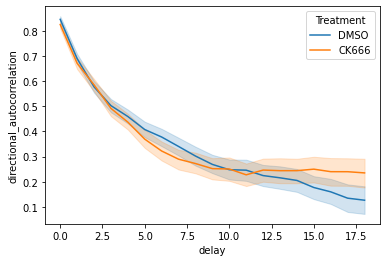

In [29]:
sns.lineplot(data = daframe, x = 'delay', y = 'directional_autocorrelation', hue = 'Treatment')

In [8]:
############### get list of metrics that are significant ttest of CELL AVERAGES ############
ModeFrame = TotalFrame.groupby(['Treatment','CellID']).mean().reset_index(level='Treatment')

siglist = []
new_remove = []
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Axis' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'bin' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'shcoeff' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Trajectory' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'frame' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'angle' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'avg' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'raw' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'intensity' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Velocity' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Travel' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Experiment' in x])
new_remove.extend(['x','y','z','OriginaltoReconError', 'RecontoOriginalError', 'Width_Rotation_Angle',
                   'Date','activity','Cell_Centroid_X', 'Cell_Centroid_Y', 'Cell_Centroid_Z'])


for c in ModeFrame.drop(columns=new_remove).columns.to_list():
    if c != 'Treatment':
        samples = [g[1].dropna() for g in ModeFrame.groupby('Treatment')[c]]
        test_stat, p_val = ss.ttest_ind(samples[0], samples[1])        
        if p_val < 0.05:
            siglist.append(c)
            print(f'Name: {c}, t-statistic: {test_stat}, p value: {p_val}')
siglist = sorted(siglist)


Name: speed, t-statistic: 3.374605897892578, p value: 0.0007940850337885991
Name: Cell_Sphericity, t-statistic: 2.004172411907343, p value: 0.045565738753198345


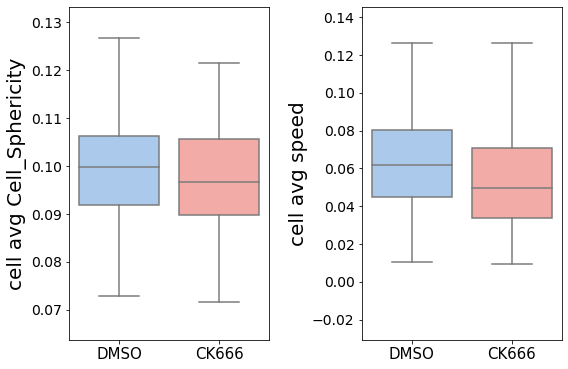

In [9]:
############### CELL AVERAGES OF SIGNIFICANT METRICS #################################
colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]


sp = math.ceil(math.sqrt(len(siglist)))
fig, axes = plt.subplots(sp, sp, figsize=(sp*4,sp*5))#, sharex=True)
axli = axes.flatten()
sigframe = TotalFrame.groupby(['Treatment','CellID'])
for i, sig in enumerate(siglist):
#     vp = sns.violinplot(data=tempframe, x='Treatment', y=sig, hue = 'Temperature', palette = colorlist, inner = None, ax=axli[i], )
    mean = sigframe[sig].mean()
    st = sigframe[sig].std()
    tempframe = pd.DataFrame({'avg':mean,'st':st}).reset_index(level='Treatment')
    
#     # Add colorbar
#     norm = plt.Normalize(tempframe['st'].min(), tempframe['st'].max())
#     sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
#     sm.set_array([])
#     cbar = fig.colorbar(sm, ax=axli[i])
    
    #plots
#     sns.stripplot(data=tempframe, x='Treatment', y='avg', hue = 'st', palette = 'viridis', ax=axli[i])
    sns.boxplot(data=tempframe, x='Treatment', y='avg', palette = colorlist,# width = 0.15, 
            fliersize=0, boxprops={'zorder': 2}, ax=axli[i])
    Q1 = tempframe['avg'].quantile(0.25)
    Q3 = tempframe['avg'].quantile(0.75)  
    IQR = Q3 - Q1
    axli[i].set_ylim(Q1 - 1.75*IQR, Q3 + 1.75*IQR)
    axli[i].set_ylabel('cell avg '+sig, fontsize=20)
    axli[i].set_xlabel('', fontsize=20)
    axli[i].tick_params('y', labelsize=14)
    #modify the labels to put bleb in two lines
    axli[i].set_xticklabels(axli[i].get_xticklabels(), fontsize = 15)
    #remove legends
    axli[i].legend_ = None

for a in range(i+1, len(axli)):
    axli[a].remove()

    
plt.tight_layout()
plt.savefig(savedir + 'Drug comparison average significant metric boxes.png', bbox_inches='tight')



In [5]:
############### get list of metrics that are significant ttest of CELL STDEVS ############
ModeFrame = TotalFrame.groupby(['Treatment','CellID']).std().reset_index(level='Treatment')

siglist = []
new_remove = []
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Axis' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'bin' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'shcoeff' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Trajectory' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'frame' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'angle' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'avg' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'raw' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'intensity' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Velocity' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Travel' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Experiment' in x])
new_remove.extend(['x','y','z','OriginaltoReconError', 'RecontoOriginalError', 'Width_Rotation_Angle',
                   'dist','Date','activity','Cell_Centroid_X', 'Cell_Centroid_Y', 'Cell_Centroid_Z'])


for c in ModeFrame.drop(columns=new_remove).columns.to_list():
    if c != 'Treatment':
        samples = [g[1].dropna() for g in ModeFrame.groupby('Treatment')[c]]
        test_stat, p_val = ss.ttest_ind(samples[0], samples[1])        
        if p_val < 0.05:
            siglist.append(c)
            print(f'Name: {c}, t-statistic: {test_stat}, p value: {p_val}')
siglist = sorted(siglist)


Name: Cell_Volume_Front, t-statistic: -2.9068839593977325, p value: 0.0038032823291159804
Name: Cell_Volume_Right, t-statistic: -2.444722731914579, p value: 0.014820995061008964
Name: Cell_SurfaceArea, t-statistic: -2.916148794733422, p value: 0.003693896096404519
Name: speed, t-statistic: 3.0758887970438713, p value: 0.002207297060481613
Name: PC1, t-statistic: -2.2304624233362915, p value: 0.026134580557207375
Name: PC4, t-statistic: -2.464180701004984, p value: 0.014048983481952201
Name: PC5, t-statistic: -2.0642056505851687, p value: 0.039484280540361405
Name: PC6, t-statistic: -2.2205947120099134, p value: 0.026800478549535215
Name: PC7, t-statistic: -2.116953690486642, p value: 0.034729058177378785
Name: Cell_Sphericity, t-statistic: -2.864532705632447, p value: 0.004341866569596889


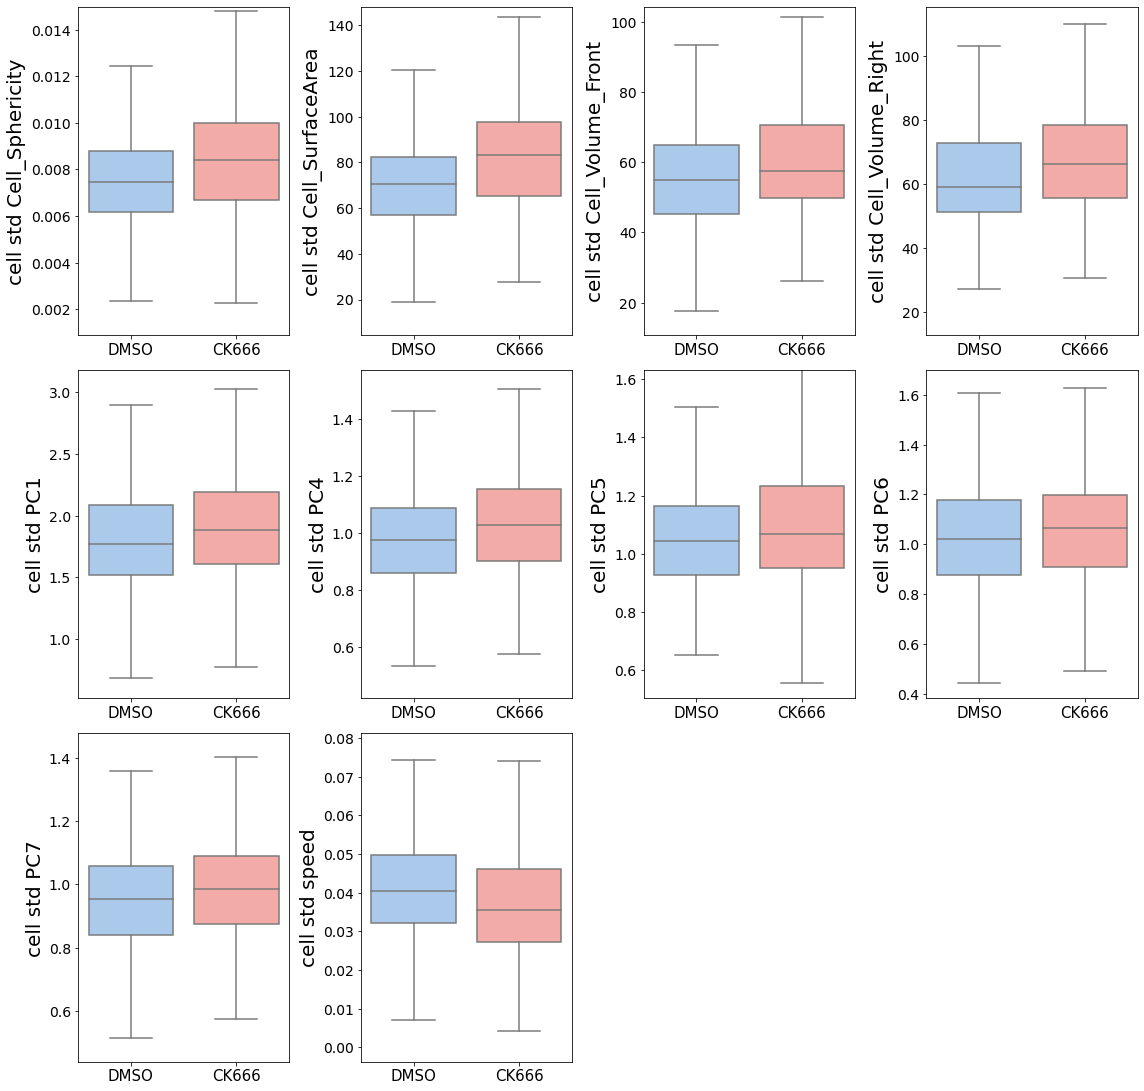

In [6]:
############### CELL AVERAGES OF SIGNIFICANT METRICS #################################
colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]


sp = math.ceil(math.sqrt(len(siglist)))
fig, axes = plt.subplots(sp, sp, figsize=(sp*4,sp*5))#, sharex=True)
axli = axes.flatten()
sigframe = TotalFrame.groupby(['Treatment','CellID'])
for i, sig in enumerate(siglist):
#     vp = sns.violinplot(data=tempframe, x='Treatment', y=sig, hue = 'Temperature', palette = colorlist, inner = None, ax=axli[i], )
    mean = sigframe[sig].mean()
    st = sigframe[sig].std()
    tempframe = pd.DataFrame({'avg':mean,'st':st}).reset_index(level='Treatment')
    
#     # Add colorbar
#     norm = plt.Normalize(tempframe['st'].min(), tempframe['st'].max())
#     sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
#     sm.set_array([])
#     cbar = fig.colorbar(sm, ax=axli[i])
    
    #plots
#     sns.stripplot(data=tempframe, x='Treatment', y='avg', hue = 'st', palette = 'viridis', ax=axli[i])
    sns.boxplot(data=tempframe, x='Treatment', y='st', palette = colorlist,# width = 0.15, 
            fliersize=0, boxprops={'zorder': 2}, ax=axli[i])
    Q1 = tempframe['st'].quantile(0.25)
    Q3 = tempframe['st'].quantile(0.75)  
    IQR = Q3 - Q1
    axli[i].set_ylim(Q1 - 1.75*IQR, Q3 + 1.75*IQR)
    axli[i].set_ylabel('cell std '+sig, fontsize=20)
    axli[i].set_xlabel('', fontsize=20)
    axli[i].tick_params('y', labelsize=14)
    #modify the labels to put bleb in two lines
    axli[i].set_xticklabels(axli[i].get_xticklabels(), fontsize = 15)
    #remove legends
    axli[i].legend_ = None

for a in range(i+1, len(axli)):
    axli[a].remove()

    
plt.tight_layout()
plt.savefig(savedir + 'Drug comparison stdev significant metric boxes.png', bbox_inches='tight')



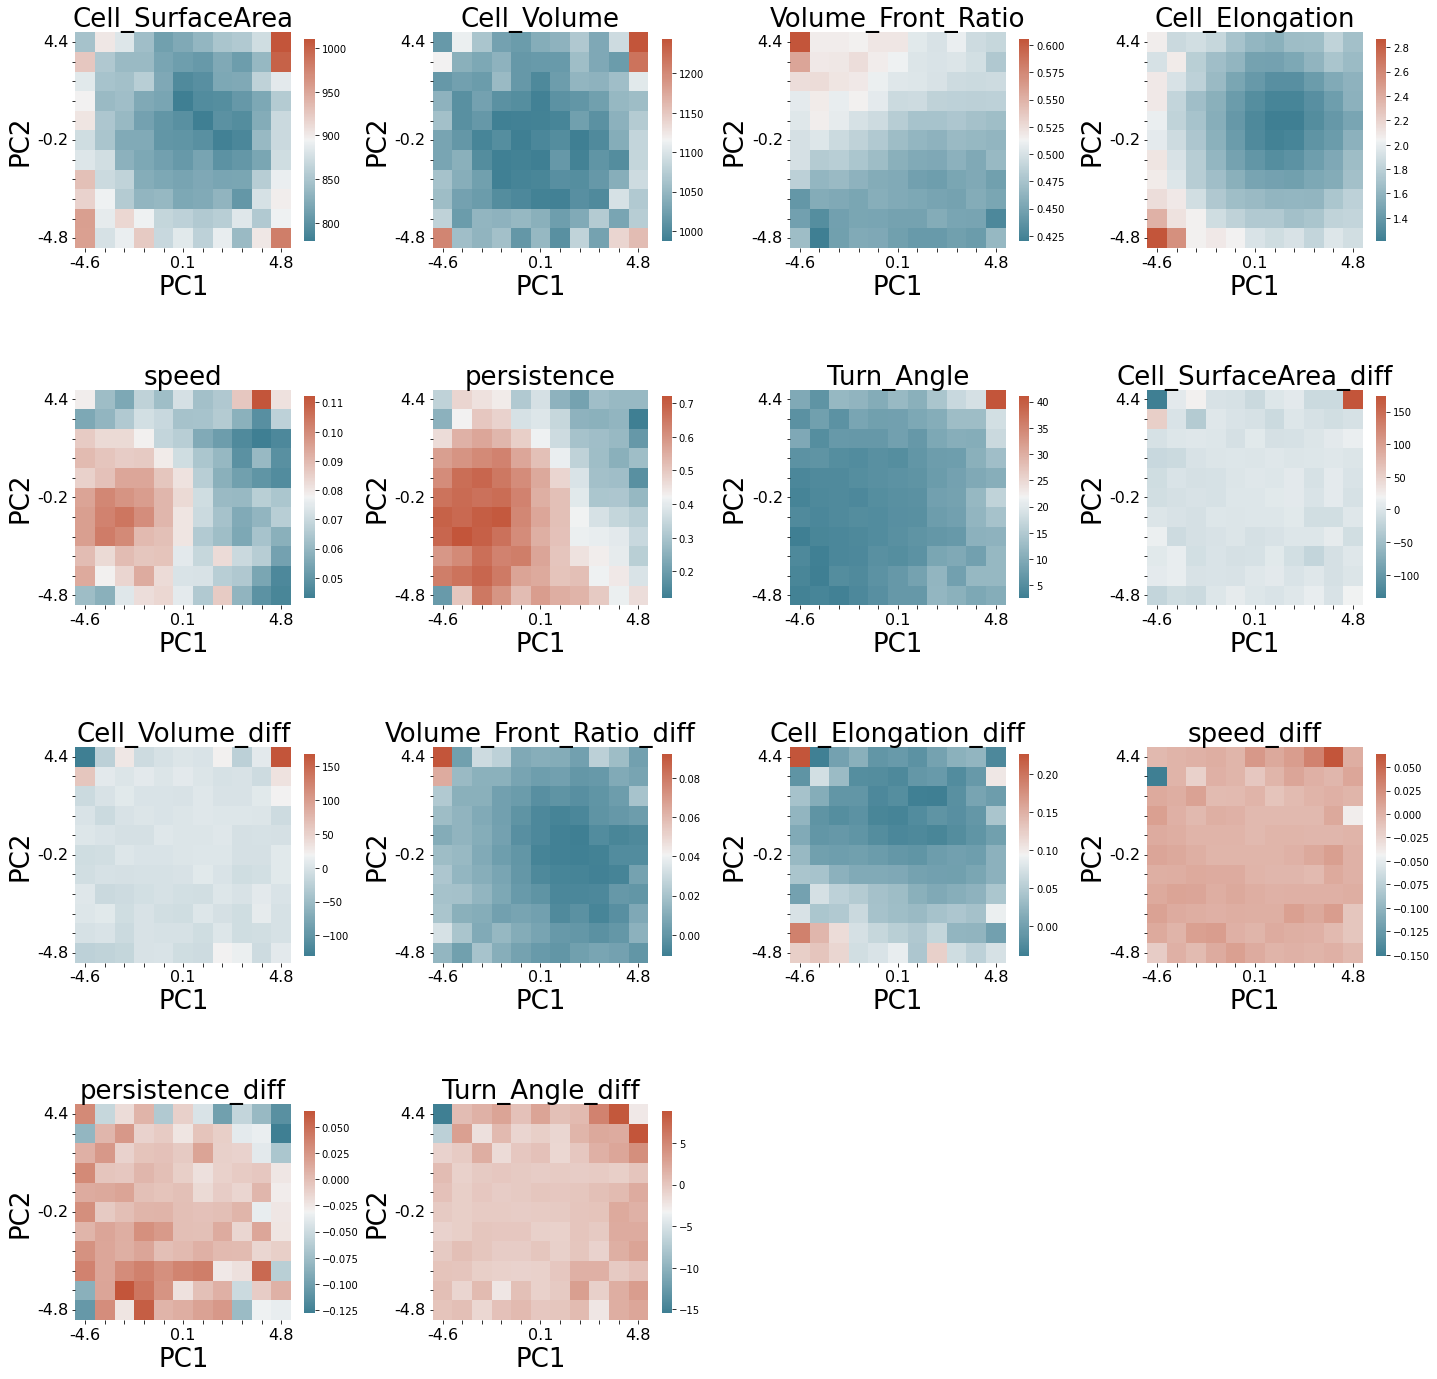

In [6]:
########### PLOT THE DISTRIBUTIONS OF SHAPE METRICS #############
############ IN THE COARSE GRAINED PHASE SPACE ###############

#add some metric differentials
metrics = ['Cell_SurfaceArea','Cell_Volume','Volume_Front_Ratio','Cell_Elongation','speed','persistence','Turn_Angle']
TotalFrame = TotalFrame.sort_values(['CellID','frame'])
diffmets = metrics.copy()
for d in metrics:
    TotalFrame[d+'_diff'] = TotalFrame[d].diff()
    diffmets.append(d+'_diff')

#make subplots
sp = math.ceil(math.sqrt(len(diffmets)))
fig, axes = plt.subplots(sp,sp,figsize=(sp*5,sp*5))

for i, ax in enumerate(axes.flatten()):
    if i<len(diffmets):
        ################ heatmap of the given metric #############
        #make numpy array with heatmap data
        bighm = np.zeros((nbins,nbins))
        for x in range(nbins):
            for y in range(nbins):
                current =  TotalFrame[(TotalFrame['PC1bins'] == x+1) & (TotalFrame['PC2bins'] == y+1)]
                if current.empty:
                    bighm[y,x] = 0
                elif len(current)==1:
                    bighm[y,x] = current[diffmets[i]]
                else:
                    bighm[y,x] = current[diffmets[i]].mean()


        #plot heatmap with seaborn
        #### use the max and the lowest non zero as min
        sns.heatmap(
            bighm,
            vmin=np.min(bighm[np.nonzero(bighm)]),
            vmax=bighm.max(), #center=0,
            cmap=sns.diverging_palette(220, 20, n=200),
            square=True,
            xticklabels = True,
            yticklabels = True,
            ax = ax,
            cbar_kws={'shrink': 0.65}
        )
        ax.set_xticklabels(
            [round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])],
            fontsize = 16
        )
        ax.set_yticklabels(
            [round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])],
            rotation=0,
            fontsize = 16
        )
        #take out all axis labels except the desired ones
        for o, l in enumerate(ax.xaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        for o, l in enumerate(ax.yaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        #set axis titles
        ax.set_xlabel('PC1', fontsize = 26)
        ax.set_ylabel('PC2', fontsize = 26)
        #correct axis orientations
        ax.invert_yaxis()
        #set title
        ax.set_title(diffmets[i], fontsize = 26)
    else:
        ax.remove()

# adjust colorbar tick label size
# cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title
axes.flatten()[0].set_ylabel('PC2', fontsize = 26)

plt.tight_layout()
plt.savefig(savedir + 'PC1_PC2 metric heatmaps.png', bbox_inches='tight')

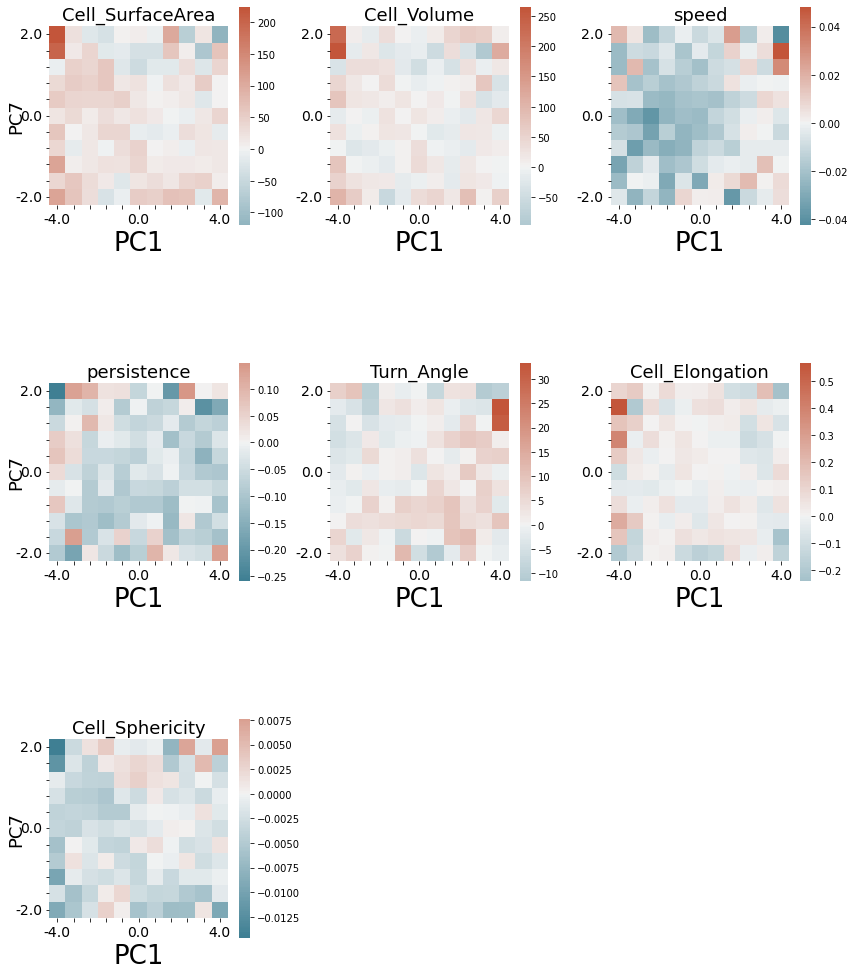

In [7]:
########### PLOT THE DIFFERENCE DISTRIBUTIONS OF SHAPE METRICS #############
############ IN THE COARSE GRAINED PHASE SPACE ###############

metrics = ['Cell_SurfaceArea','Cell_Volume','speed','persistence','Turn_Angle','Cell_Elongation', 'Cell_Sphericity']

sp = math.ceil(math.sqrt(len(metrics)))
fig, axes = plt.subplots(sp, sp, figsize=(sp*4,sp*5))#, sharex=True)
axf = axes.flatten()
for i, met in enumerate(metrics):
    ax = axf[i]
    ################ heatmap of the given metric #############
    #make numpy array with heatmap data
    bighm = np.zeros((len(TotalFrame.Treatment.unique()),nbins,nbins))
    for n in range(bighm.shape[0]):
        mdf = TotalFrame[TotalFrame.Treatment==TotalFrame.Treatment.unique()[n]]
        for x in range(nbins):
            for y in range(nbins):
                current =  mdf[(mdf['PC1bins'] == x+1) & (mdf['PC7bins'] == y+1)].dropna(subset=[met])
                if current.empty:
                    bighm[n,y,x] = 0
                elif len(current)==1:
                    bighm[n,y,x] = current[met]
                else:
                    bighm[n,y,x] = current[met].mean()

    diffhm = bighm[1,:,:]-bighm[0,:,:]
    #plot heatmap with seaborn
    #### use the max and the lowest non zero as min
    sns.heatmap(
        diffhm,
        #vmin=np.min(bighm[np.nonzero(bighm)]),
        #vmax=np.max(bighm),
        center=0,
        cmap=sns.diverging_palette(220, 20, n=200),
        square=True,
        xticklabels = True,
        yticklabels = True,
        ax = ax,
        cbar_kws={'shrink': 0.65}
    )
    ax.set_xticklabels(
            [round(x,1) for x in centers.PC1.to_list()],
            fontsize = 14
        )
    ax.set_yticklabels(
        [round(x,1) for x in centers.PC7.to_list()],
        rotation=0,
        fontsize = 14
    )
    #take out all axis labels except the desired ones
    for o, l in enumerate(ax.xaxis.get_ticklabels()):
        if o%5 != 0:
            l.set_visible(False)
    for o, l in enumerate(ax.yaxis.get_ticklabels()):
        if o%5 != 0:
            l.set_visible(False)
    #set axis titles
    ax.set_xlabel('PC1', fontsize = 26)      
    if (i%sp ==0):
        ax.set_ylabel('PC7', fontsize = 18, labelpad=-10)
#         else:
#             ax.set_ylabel(f'PC2', fontsize = 26, labelpad=-10)
    #correct axis orientations
    ax.invert_yaxis()
    #set title
    ax.set_title(met, fontsize = 18)
for a in range(i+1, len(axf)):
    axf[a].remove()

# adjust colorbar tick label size
# cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title

plt.tight_layout()
plt.savefig(savedir + 'PC1_PC7 difference heatmaps.png', bbox_inches='tight')

C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\scipy\stats\stats.py:3621: F_onewayBadInputSizesWarning: at least one input has length 0
  warnings.warn(F_onewayBadInputSizesWarning('at least one input '


Name Cell_Centroid_X          Multiple Comparison of Means - Tukey HSD, FWER=0.05         
      group1          group2   meandiff p-adj  lower    upper  reject
---------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv  13.8299   0.0  12.5991 15.0607   True
Chem_Directed_Chem Random_Chem   2.3165   0.0   1.1808  3.4522   True
Chem_Directed_Chem Random_Galv   6.5544   0.0   5.2757  7.8331   True
         Galv_Galv Random_Chem -11.5134   0.0 -12.6137 -10.413   True
         Galv_Galv Random_Galv  -7.2755   0.0  -8.5229 -6.0281   True
       Random_Chem Random_Galv   4.2379   0.0   3.0842  5.3916   True
---------------------------------------------------------------------
Name Cell_Centroid_Y          Multiple Comparison of Means - Tukey HSD, FWER=0.05         
      group1          group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv   4.8776    0.0  

Name Cell_intensity_99pct          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
      group1          group2   meandiff p-adj   lower    upper  reject
----------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv  -6.9099    0.0 -10.4941 -3.3257   True
Chem_Directed_Chem Random_Chem   9.9033    0.0    6.596 13.2106   True
Chem_Directed_Chem Random_Galv  -2.6488 0.2602  -6.3725  1.0749  False
         Galv_Galv Random_Chem  16.8132    0.0  13.6089 20.0175   True
         Galv_Galv Random_Galv   4.2611 0.0138   0.6286  7.8937   True
       Random_Chem Random_Galv -12.5521    0.0 -15.9117 -9.1924   True
----------------------------------------------------------------------
Name Cell_intensity_max          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
      group1          group2   meandiff p-adj   lower    upper  reject
----------------------------------------------------------------------
Chem_Directed_Chem   Galv_G

Name PC8          Multiple Comparison of Means - Tukey HSD, FWER=0.05         
      group1          group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv   1.4552    0.0  1.2838  1.6265   True
Chem_Directed_Chem Random_Chem   0.3745    0.0  0.2164  0.5326   True
Chem_Directed_Chem Random_Galv   1.2123    0.0  1.0343  1.3903   True
         Galv_Galv Random_Chem  -1.0807    0.0 -1.2339 -0.9275   True
         Galv_Galv Random_Galv  -0.2429 0.0019 -0.4165 -0.0692   True
       Random_Chem Random_Galv   0.8378    0.0  0.6772  0.9984   True
---------------------------------------------------------------------
Name PC9          Multiple Comparison of Means - Tukey HSD, FWER=0.05         
      group1          group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv   0.1491 0.0833 -0.0127  0.3108  False
Ch

Name nucleus_Structure_intensity_1pct       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
      group1          group2   meandiff p-adj lower upper reject
----------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv      nan   nan   nan   nan  False
Chem_Directed_Chem Random_Chem      nan   nan   nan   nan  False
Chem_Directed_Chem Random_Galv      nan   nan   nan   nan  False
         Galv_Galv Random_Chem      nan   nan   nan   nan  False
         Galv_Galv Random_Galv      nan   nan   nan   nan  False
       Random_Chem Random_Galv      nan   nan   nan   nan  False
----------------------------------------------------------------
Name nucleus_Structure_intensity_99pct       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
      group1          group2   meandiff p-adj lower upper reject
----------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv      nan   nan   nan   nan  False
Chem_Directed

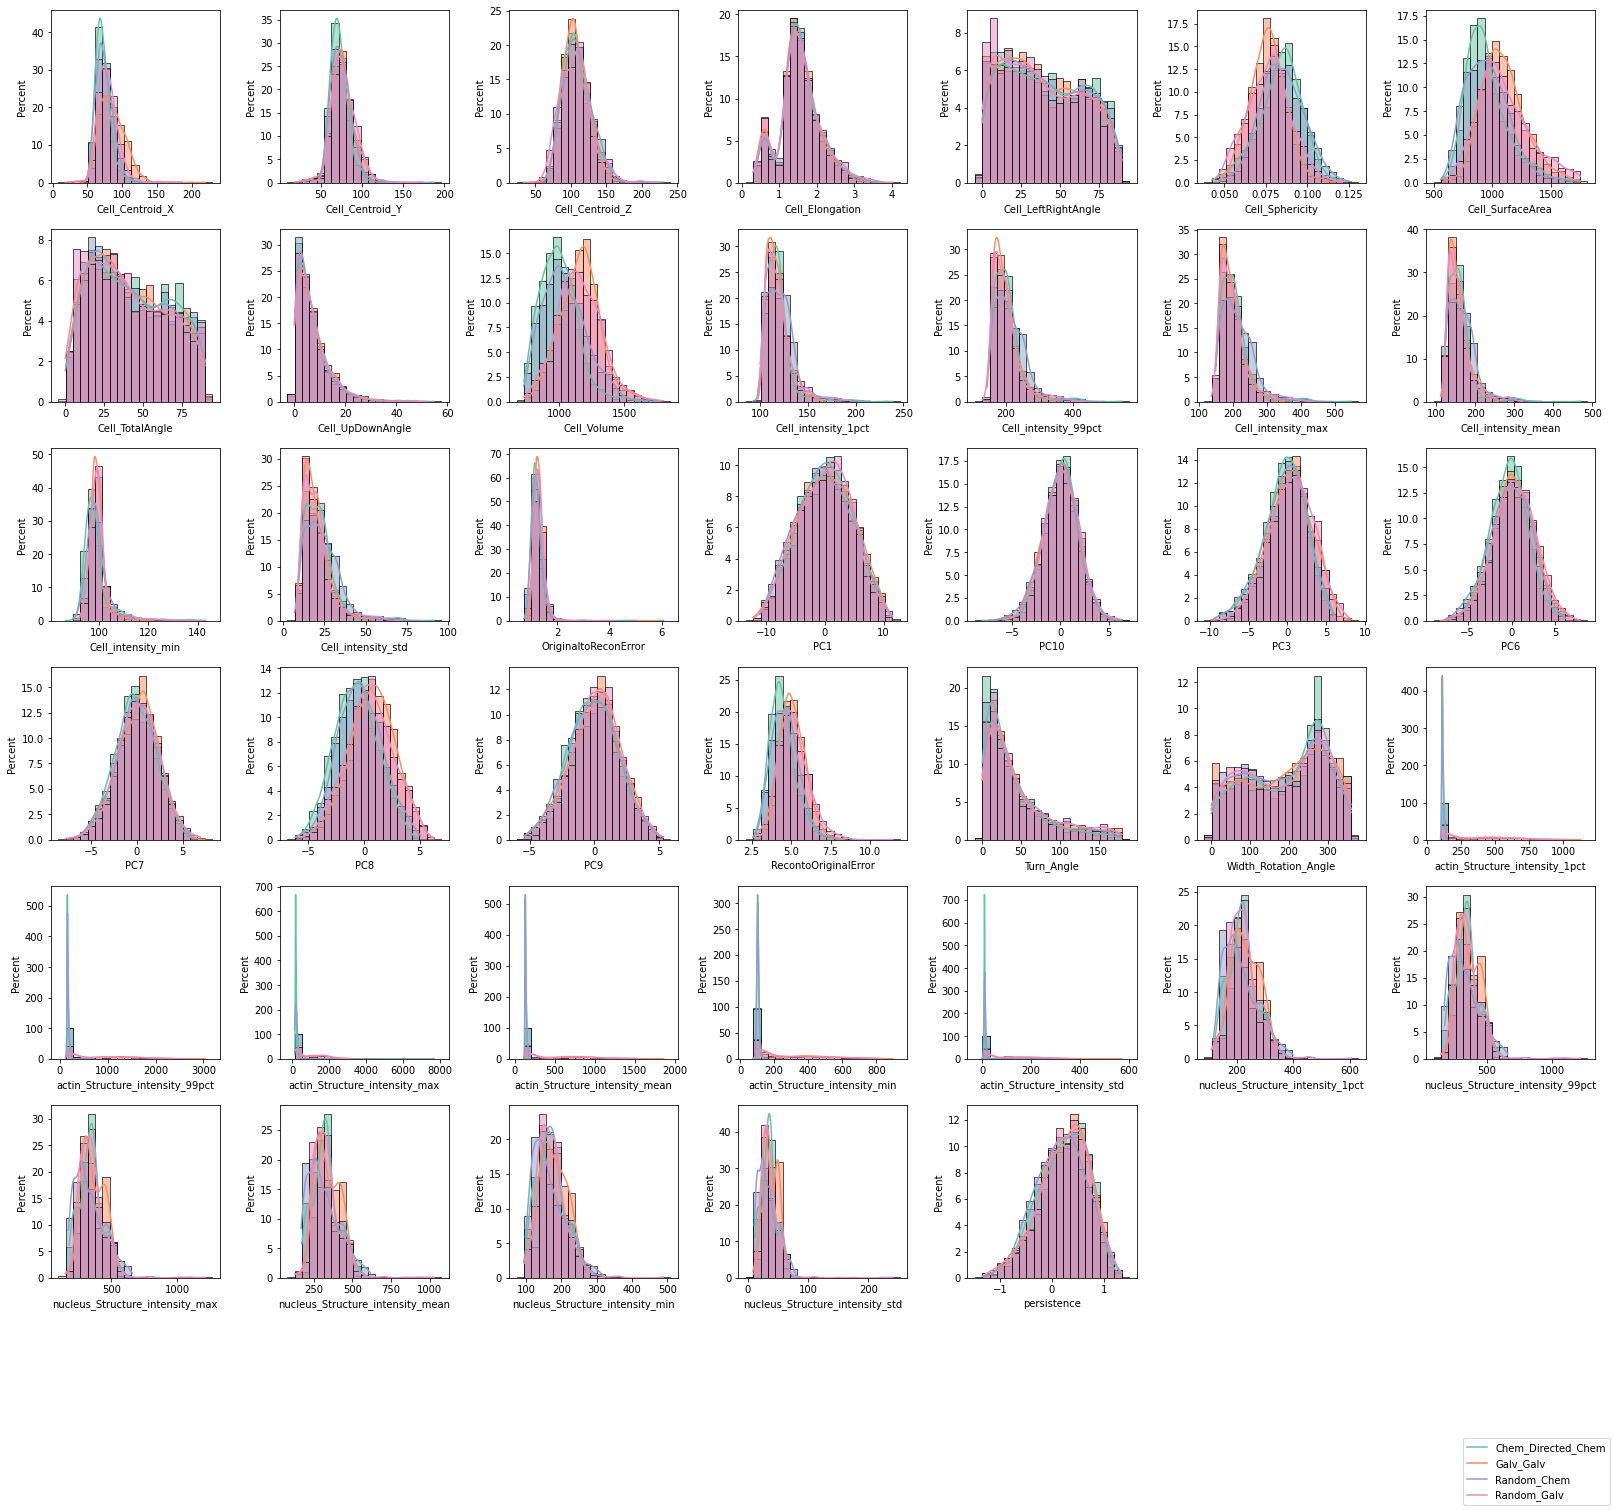

In [68]:
############### get list of metrics that are significant by migration mode using anova ############
ModeFrame = TotalFrame.copy()

import scipy.stats as ss
siglist = []
new_remove = to_remove.copy()
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'cell' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'frame' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'angle' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'avg' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'dist' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'activity' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'structure' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'ID' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Experiment' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Migration_Mode' in x])

for c in ModeFrame.drop(columns=new_remove).columns.to_list():
    samples = [g[1].dropna() for g in ModeFrame.groupby(['Migration_Mode','Experiment'])[c]]
    f_val, p_val = ss.f_oneway(*samples)
#     print(f'Name: {c}, F value: {f_val}, p value: {p_val}')
    if p_val < 0.05:
        siglist.append(c) 
siglist = sorted(siglist)
from statsmodels.stats.multicomp import pairwise_tukeyhsd
for c in siglist:
    print(f'Name {c}', pairwise_tukeyhsd(ModeFrame[c], 
                                         [one+'_'+two for one, two in zip(ModeFrame['Migration_Mode'].to_list(), ModeFrame['Experiment'].to_list())]))

# units= ['(a.u.)','(a.u.)','(µm$^3$)','(a.u.)','(a.u.)','(µm$^2$)','(µm$^3$)',
#         '(a.u.)','(a.u.)']


################# LOOK AT STAT DISTRIBUTIONS OF SIGNIFICANT STATS ######################
import seaborn as sns

colors = sns.color_palette("Set2")
colors = list(colors.as_hex())


# colors = list(sns.color_palette('deep').as_hex())

CoRo = math.ceil(math.sqrt(len(siglist)))
row = 0
fig, axes = plt.subplots(CoRo, CoRo, figsize=(3.2*CoRo,3*CoRo))#, sharex=True)

for i, met in enumerate(siglist):

    
    #get the metric in question separated by migration mode
    samples = [g[1].dropna() for g in ModeFrame.groupby(['Migration_Mode','Experiment'])[met]]
    
        
    #get bins so that the widths between all types are the same
    maxx = max([max(x) for x in samples])
    minn = min([min(x) for x in samples])
    binwidth = (maxx-minn)*0.05
    maxx = maxx + binwidth
    minn = minn - binwidth
    binss = np.linspace(minn,maxx,round((maxx-minn)/binwidth))
    
    #plot the data
    ax = axes[row,(i-((CoRo-1)*row)-row)]
    sns.histplot(ax = ax, data=samples[0], bins=binss, stat='percent', color = colors[0], kde = True)
    sns.histplot(ax = ax, data=samples[1], bins=binss, stat='percent', color = colors[1], kde = True)
    sns.histplot(ax = ax, data=samples[2], bins=binss, stat='percent', color = colors[2], kde = True)
    sns.histplot(ax = ax, data=samples[3], bins=binss, stat='percent', color = colors[3], kde = True)
#     ax.set_ylabel(met)#, fontsize = 1.75*CoRo)
    if (i+1)%(CoRo) ==0:
        row = row + 1


ax = axes[row,(i-((CoRo-1)*row)-row)]
fig.legend(['_'.join(g) for g, i in ModeFrame.groupby(['Migration_Mode','Experiment'])], loc = 'lower right')

#delete all of the subplots that are unused
for a in range(i,CoRo**2):
    fig.delaxes(axes[row,(a-((CoRo-1)*row)-row)])
    if (a+1)%(CoRo) ==0:
        row = row + 1

# #     ax.set_ylabel(Nucleus_Metrics.iloc[:,i].name)

# # axes[0,0].set_title("Cell", fontsize = 16)
# # axes[0,1].set_title("Nucleus", fontsize = 16)
# # [ax.set_xlabel("Component value") for ax in axes[-1,:]];
# plt.legend(ModeFrame.Migration_Mode.unique(), loc ='lower right')
plt.tight_layout()
# plt.savefig(folder_fl + 'Significant Shape Metric Histograms.png', bbox_inches='tight')

In [10]:
############### linearize PC cycle #############

origin = [7, 7]
whichpcs = [1,7]
binrange = 10
direction = 'clockwise'

angframe = linear_cycle_utils.linearize_cycle_continuous(
            TotalFrame, 
            centers,
            origin, 
            whichpcs,  
            binrange, 
            direction,)


# #### get a movie of the average SH coeffs around the cycle
# coeff_df = pd.read_csv(datadir + 'Shape_Metrics_with_Digitized_PCs.csv', index_col=0)
# coeffframe = angframe.merge(coeff_df[[x for x in coeff_df.columns.to_list() if 'shco' in x]+['cell']],
#                               left_on = 'cell', right_on = 'cell')
# for t, treat in coeffframe.groupby('Treatment'):
#     linear_cycle_utils.animate_linear_cycle_shcoeffs(
#                             coeffframe,
#                             savedir,
#                             t,
#                             whichpcs,
#                             binrange,
#                             lmax = 10,
#                             smooth = False
#                             )


In [ ]:
############### linear statistics #####################
####### two-way ANOVA with Cycle angle and Treatment


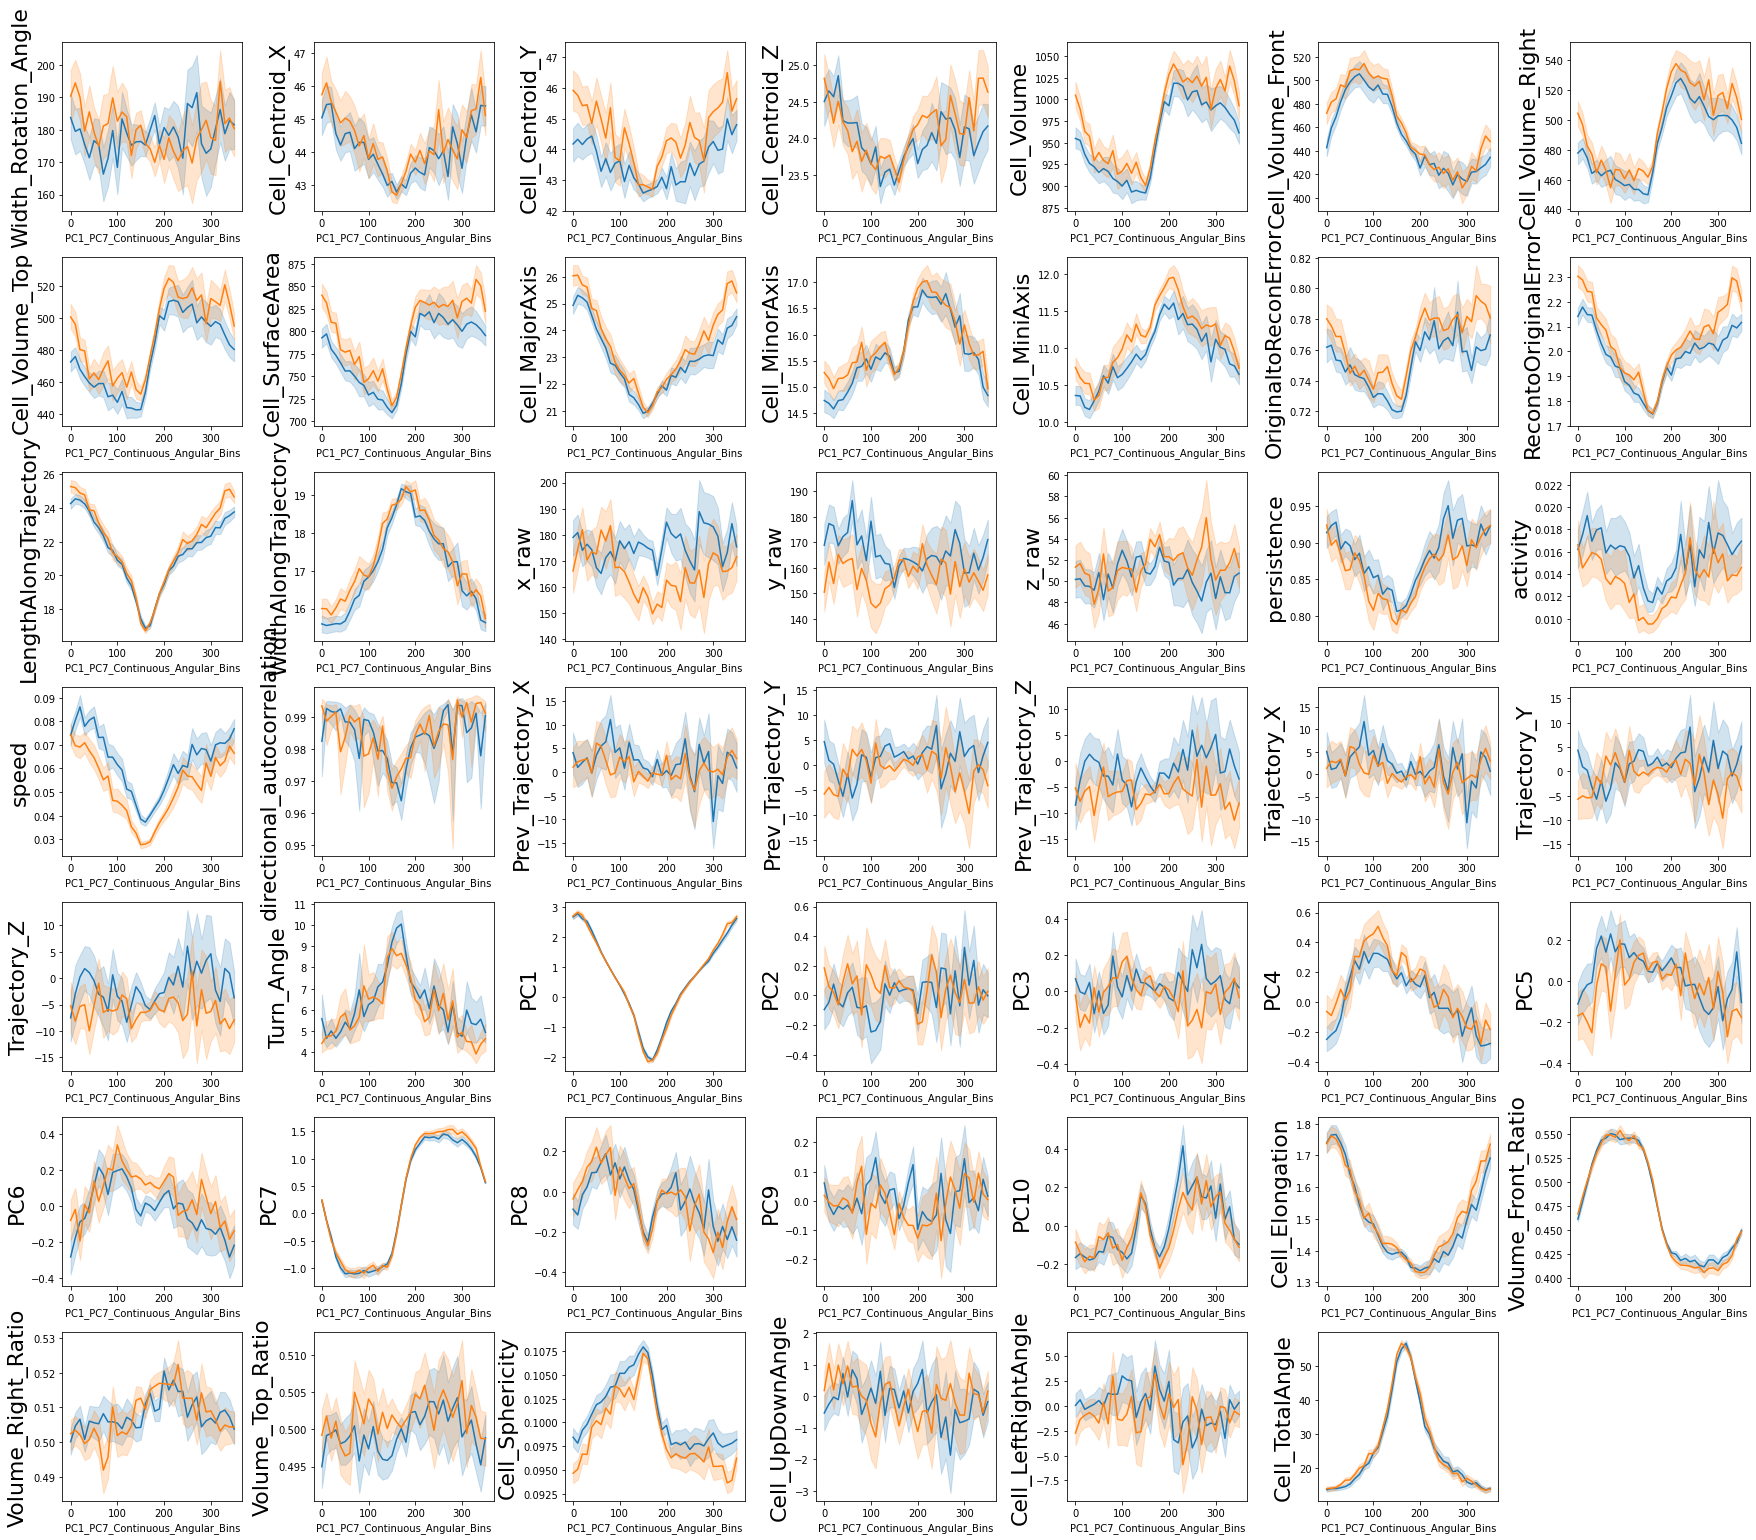

In [11]:
################# LOOK STATS AROUND 1D CYCLE ######################
removeex = []
removeex.extend([x for x in angframe.columns if 'Euler' in x])
removeex.extend([x for x in angframe.columns if 'avg' in x])
removeex.extend([x for x in angframe.columns if 'PC1_PC2' in x])
removeex.extend([x for x in angframe.columns if 'intensity' in x])
removeex.extend([x for x in angframe.columns if 'Velocity' in x])
removeex.extend([x for x in angframe.columns if 'Coord' in x])
removeex.extend([x for x in angframe.columns if 'Vec' in x])
removeex.extend([x for x in angframe.columns if 'bins' in x])
removeex.extend(['cell','CellID','x','y','z','structure','frame','Treatment','Experiment',
                'Experiment_Number','Date'])
newframe = angframe.drop(columns =removeex)


CoRo = math.ceil(math.sqrt(len(newframe.columns)))
row = 0
fig, axes = plt.subplots(CoRo, CoRo, figsize=(3.5*CoRo,3*CoRo))#, sharex=True)

for i, ax in enumerate(axes.flatten()):
    if i<len(newframe.columns):
        if newframe.iloc[:,i].name == f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins':
            ax.remove()
            continue
        sns.lineplot(data = TotalFrame, x=f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins', 
                     y = newframe.iloc[:,i].name, hue = 'Treatment', ax = ax)
        ax.set_ylabel(newframe.iloc[:,i].name)#, fontsize = 1.75*CoRo)
        ax.legend_ = None
        ax.set_ylabel(ax.get_ylabel(), fontsize = 22)
    else:
        ax.remove()


plt.tight_layout()
plt.savefig(savedir + f'PC{whichpcs[0]}_PC{whichpcs[1]} Shape Metrics 1D Continuous PCs.png', bbox_inches='tight')

In [8]:
############## bootstrap around the linear cycle for metrics ###################

if os.path.exists(savedir + 'linear CGPS bootstrapped metric.csv'):
    allavgsframe = pd.read_csv(savedir + 'linear CGPS bootstrapped metric.csv', index_col=0)
    print('Opened bootstrap file')
else:    
    
    samplesize = 50
    bsiters = 1000

    ### generate the dataframe with all of the sampled data
    treatlist = []
    celllist = []
    bslist = []
    for t in TotalFrame.Treatment.unique():
        for b in range(bsiters):
            treattemp = TotalFrame[TotalFrame.Treatment == t]
            celllist.extend(random.sample(list(treattemp.CellID.unique()), samplesize))
            treatlist.extend([t]*samplesize)
            bslist.extend([b]*samplesize)

    allbs = pd.DataFrame({'Treatment':treatlist,
                   'bsiter':bslist,
                   'CellID':celllist})


    ### sample linearized dataframe and get averages
    allavgs = []
    for i, bi in allbs.groupby('bsiter'):
        tempangframe = angframe[angframe.CellID.isin(bi.CellID.to_list())]
        for a, ab in tempangframe.groupby(f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins'):
            ab['bsiter'] = [i]* len(ab)
            abavg = ab.mean()
            for index, value in zip(['cell','CellID','structure','Treatment','Experiment'],
                                   ab[['cell','CellID','structure','Treatment','Experiment']].iloc[0].values):
                abavg[index] = value
            allavgs.append(abavg)

    allavgsframe = pd.DataFrame(allavgs)
    allavgsframe.to_csv(savedir + 'linear CGPS bootstrapped metric.csv')

Opened bootstrap file


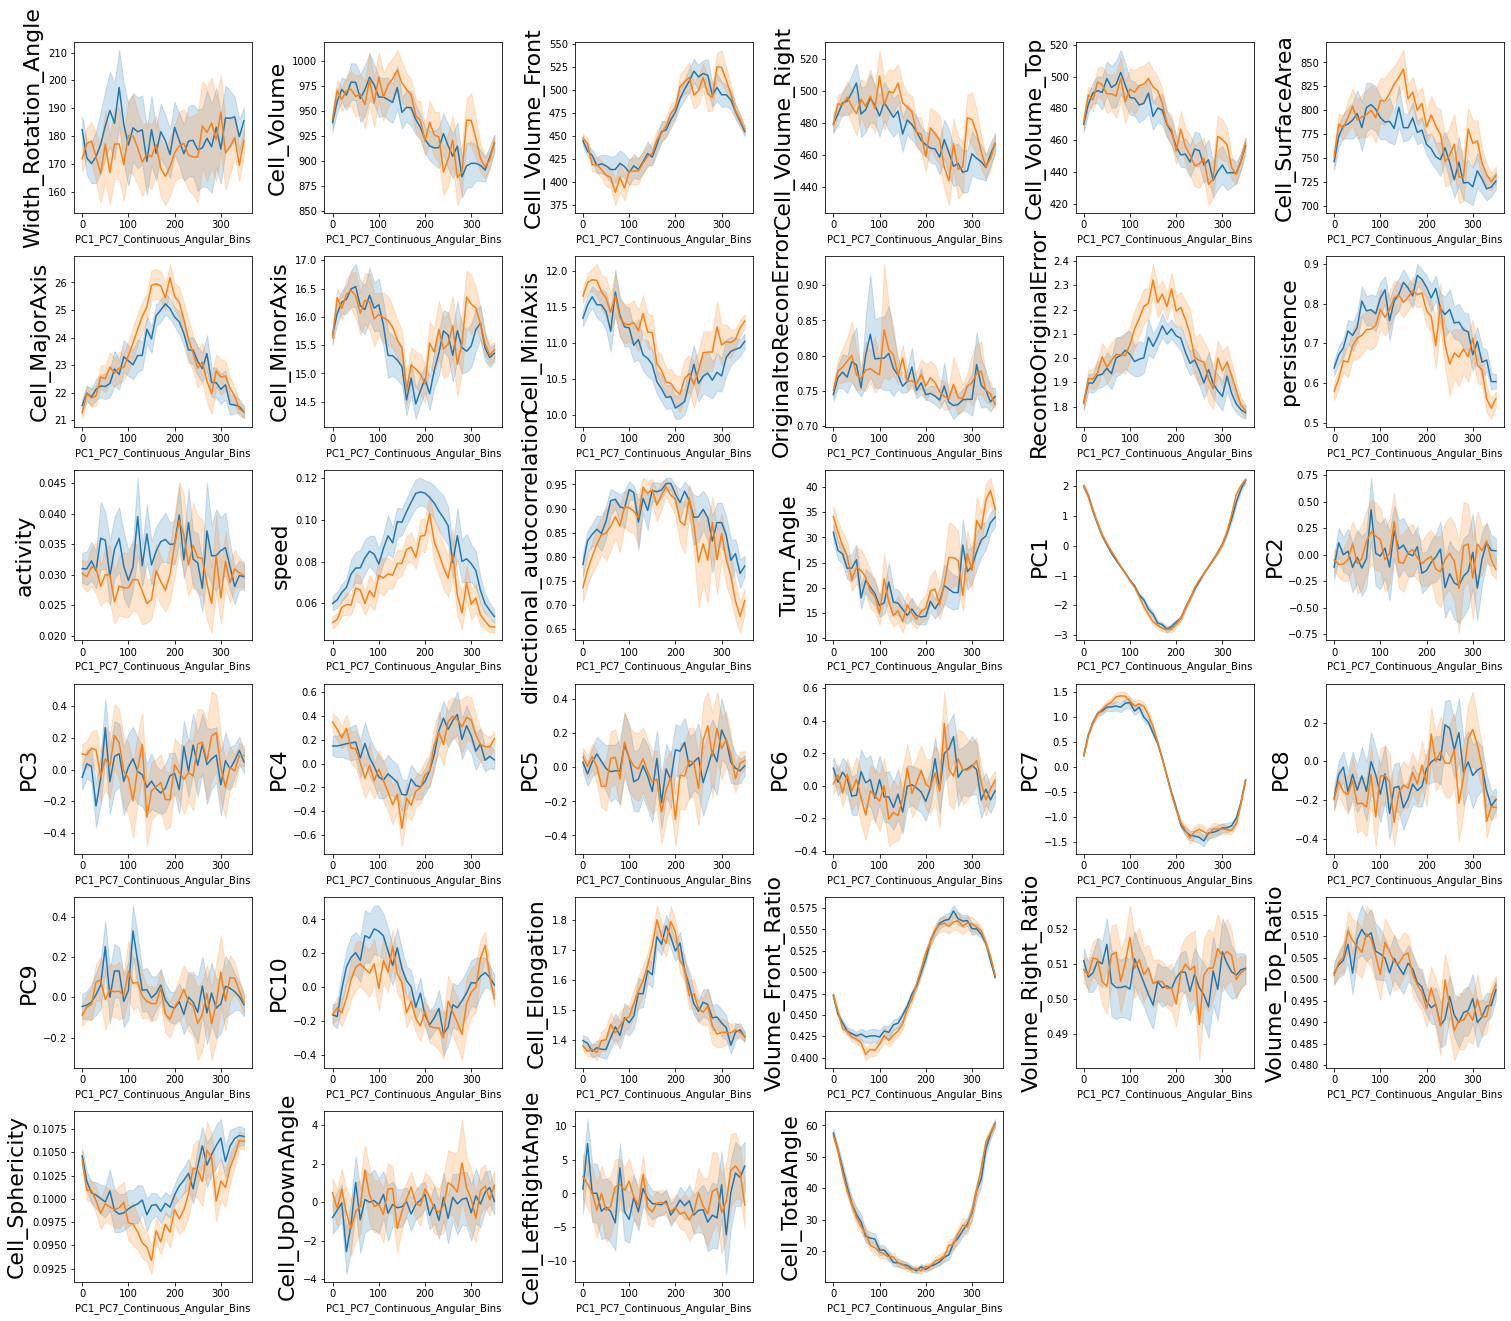

In [5]:


################# LOOK STATS AROUND 1D CYCLE ######################
removeex = []
removeex.extend([x for x in allavgsframe.columns if 'Euler' in x])
removeex.extend([x for x in allavgsframe.columns if 'avg' in x])
removeex.extend([x for x in allavgsframe.columns if 'PC1_PC2' in x])
removeex.extend([x for x in allavgsframe.columns if 'intensity' in x])
removeex.extend([x for x in allavgsframe.columns if 'Velocity' in x])
removeex.extend([x for x in allavgsframe.columns if 'Coord' in x])
removeex.extend([x for x in allavgsframe.columns if 'Centroid' in x])
removeex.extend([x for x in allavgsframe.columns if 'Trajectory' in x])
removeex.extend([x for x in allavgsframe.columns if 'Vec' in x])
removeex.extend([x for x in allavgsframe.columns if 'bins' in x])
removeex.extend(['cell','CellID','x','y','z','structure','frame','Treatment','Experiment',
                'Experiment_Number','Date','bsiter'])
newframe = allavgsframe.drop(columns =removeex)


CoRo = math.ceil(math.sqrt(len(newframe.columns)))
row = 0
fig, axes = plt.subplots(CoRo, CoRo, figsize=(3.5*CoRo,3*CoRo))#, sharex=True)

for i, ax in enumerate(axes.flatten()):
    if i<len(newframe.columns):
        if newframe.iloc[:,i].name == f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins':
            ax.remove()
            continue
        sns.lineplot(data = TotalFrame, x=f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins', 
                     y = newframe.iloc[:,i].name, hue = 'Treatment', ax = ax)
        ax.set_ylabel(newframe.iloc[:,i].name)#, fontsize = 1.75*CoRo)
        ax.legend_ = None
        ax.set_ylabel(ax.get_ylabel(), fontsize = 22)
    else:
        ax.remove()


plt.tight_layout()
plt.savefig(savedir + f'PC{whichpcs[0]}_PC{whichpcs[1]} Shape Metrics 1D Continuous PCs with bootstrapping.png', bbox_inches='tight')

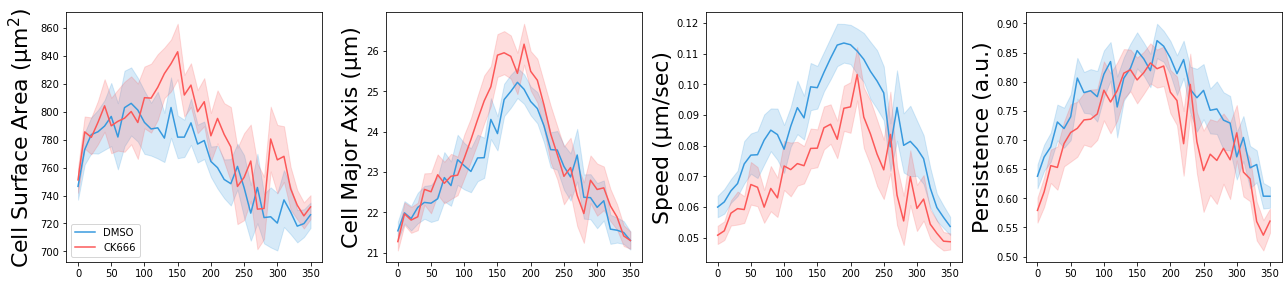

In [9]:


################# LOOK STATS AROUND 1D CYCLE ######################
colorlist = ['#3799de','#fc5858']
metrics = ['Cell_SurfaceArea','Cell_MajorAxis','speed','persistence']
metlabels = ['Cell Surface Area (µm$^2$)', 'Cell Major Axis (µm)',
             'Speed (µm/sec)','Persistence (a.u.)']
newframe = allavgsframe[metrics]


CoRo = math.ceil(math.sqrt(len(newframe.columns)))
row = 0
fig, axes = plt.subplots(1, len(metrics), figsize=(4.5*len(metrics),1*len(metrics)))#, sharex=True)

for i, ax in enumerate(axes.flatten()):
    if i<len(newframe.columns):
        if newframe.iloc[:,i].name == f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins':
            ax.remove()
            continue
        sns.lineplot(data = TotalFrame, x=f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins', 
                     y = newframe.iloc[:,i].name, palette = colorlist, hue = 'Treatment', ax = ax)
        ax.set_ylabel(metlabels[i])#, fontsize = 1.75*CoRo)
        ax.set_ylabel(ax.get_ylabel(), fontsize = 22)
        ax.set_xlabel('')
        if i!=0:
            ax.legend_ = None
        else:
            ax.legend(loc='lower left')
    else:
        ax.remove()


plt.tight_layout()
plt.savefig(savedir + f'PC{whichpcs[0]}_PC{whichpcs[1]} specific Shape Metrics 1D Continuous PCs with bootstrapping.png',
            bbox_inches='tight')